In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import data

HAS_SKIMAGE = True
%matplotlib inline

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=25):
    row, col = image.shape
    dtype = image.dtype
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image.astype(np.float32) + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(dtype)
    return noisy_image

def add_salt_and_pepper_noise(image, amount=0.04, salt_vs_pepper=0.5):
    noisy_image = np.copy(image)
    row, col = image.shape
    num_pixels = row * col
    num_salt = int(np.ceil(amount * num_pixels * salt_vs_pepper))
    coords_salt = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords_salt[0], coords_salt[1]] = 255 
    num_pepper = int(np.ceil(amount * num_pixels * (1.0 - salt_vs_pepper)))
    coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords_pepper[0], coords_pepper[1]] = 0  
    return noisy_image

def add_speckle_noise(image, sigma=0.1):
    dtype = image.dtype
    row, col = image.shape
    noise = np.random.normal(0, sigma, (row, col))
    noisy_image = image.astype(np.float32) + image.astype(np.float32) * noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(dtype)
    return noisy_image


#Parametrs 

In [ ]:
gaussian_sigma = 25     
sp_amount = 0.05        
sp_ratio = 0.5          
speckle_sigma = 0.15    

gray_image = None
image_source = "N/A"
image_path = "."

gaussian_ksize = (5, 5) 
median_ksize = 5        
bilateral_d = 9         
bilateral_sigma_color = 75 
bilateral_sigma_space = 75


Loaded standard 'cameraman' image using scikit-image.
Image loaded successfully. Shape: (512, 512), Type: uint8


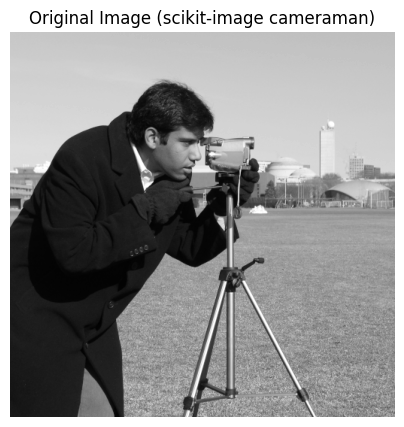

In [ ]:
if HAS_SKIMAGE:
    try:
        gray_image = data.camera() 
        print("Loaded standard 'cameraman' image using scikit-image.")
        image_source = 'scikit-image cameraman'
    except Exception as e:
        print(f"Error loading 'cameraman' from scikit-image: {e}")
        print("Falling back to loading from file.")
        HAS_SKIMAGE = False

if gray_image is None and not HAS_SKIMAGE:
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at '{image_path}'")
    else:
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_source = image_path
        if gray_image is None:
            print(f"Error: Could not load image from file '{image_path}' using OpenCV.")
        else:
            print(f"Loaded image from file: '{image_path}'")


if gray_image is None:
    print("\nERROR: Image loading failed. Cannot proceed.")

else:
    print(f"Image loaded successfully. Shape: {gray_image.shape}, Type: {gray_image.dtype}")

    plt.figure(figsize=(5, 5))
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Original Image ({image_source})')
    plt.axis('off')
    plt.show()

In [5]:
if gray_image is not None:
    gaussian_noisy = add_gaussian_noise(gray_image, sigma=gaussian_sigma)
    salt_pepper_noisy = add_salt_and_pepper_noise(gray_image, amount=sp_amount, salt_vs_pepper=sp_ratio)
    speckle_noisy = add_speckle_noise(gray_image, sigma=speckle_sigma)
    print("Noise added successfully.")
else:
    print("Skipping noise addition because the image was not loaded.")
    gaussian_noisy, salt_pepper_noisy, speckle_noisy = None, None, None

Noise added successfully.


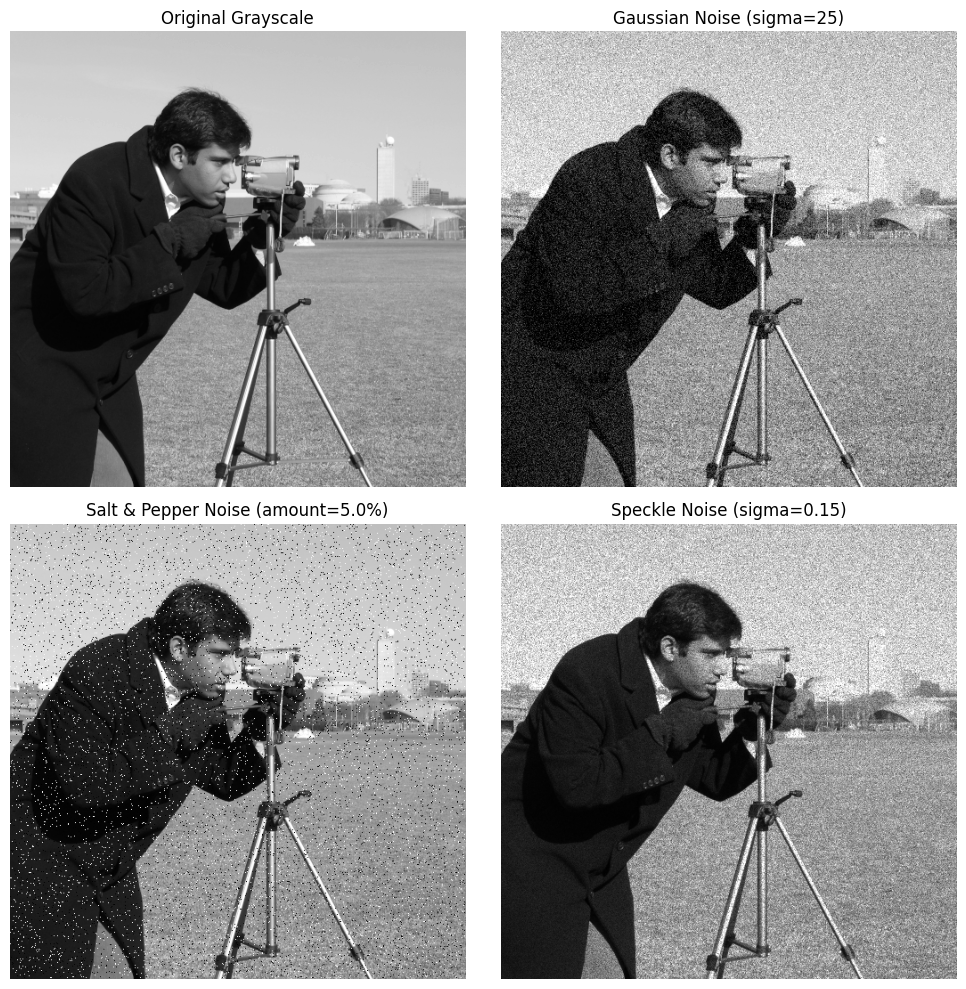

In [6]:
if gray_image is not None and gaussian_noisy is not None:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    cmap = 'gray'

    axes[0, 0].imshow(gray_image, cmap=cmap)
    axes[0, 0].set_title('Original Grayscale')
    axes[0, 0].axis('off') 
    axes[0, 1].imshow(gaussian_noisy, cmap=cmap)
    axes[0, 1].set_title(f'Gaussian Noise (sigma={gaussian_sigma})')
    axes[0, 1].axis('off')
    axes[1, 0].imshow(salt_pepper_noisy, cmap=cmap)
    axes[1, 0].set_title(f'Salt & Pepper Noise (amount={sp_amount*100:.1f}%)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(speckle_noisy, cmap=cmap)
    axes[1, 1].set_title(f'Speckle Noise (sigma={speckle_sigma})')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
if gray_image is not None:
    print("Applying filters (Gaussian, Median, Bilateral)...")
    gauss_filtered_g = cv2.GaussianBlur(gaussian_noisy, gaussian_ksize, 0)
    median_filtered_g = cv2.medianBlur(gaussian_noisy, median_ksize)
    bilateral_filtered_g = cv2.bilateralFilter(gaussian_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)

    gauss_filtered_sp = cv2.GaussianBlur(salt_pepper_noisy, gaussian_ksize, 0)
    median_filtered_sp = cv2.medianBlur(salt_pepper_noisy, median_ksize)
    bilateral_filtered_sp = cv2.bilateralFilter(salt_pepper_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)

    gauss_filtered_s = cv2.GaussianBlur(speckle_noisy, gaussian_ksize, 0)
    median_filtered_s = cv2.medianBlur(speckle_noisy, median_ksize)
    bilateral_filtered_s = cv2.bilateralFilter(speckle_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
    print("Filtering complete.")

Applying filters (Gaussian, Median, Bilateral)...
Filtering complete.


Displaying final comparison plot.


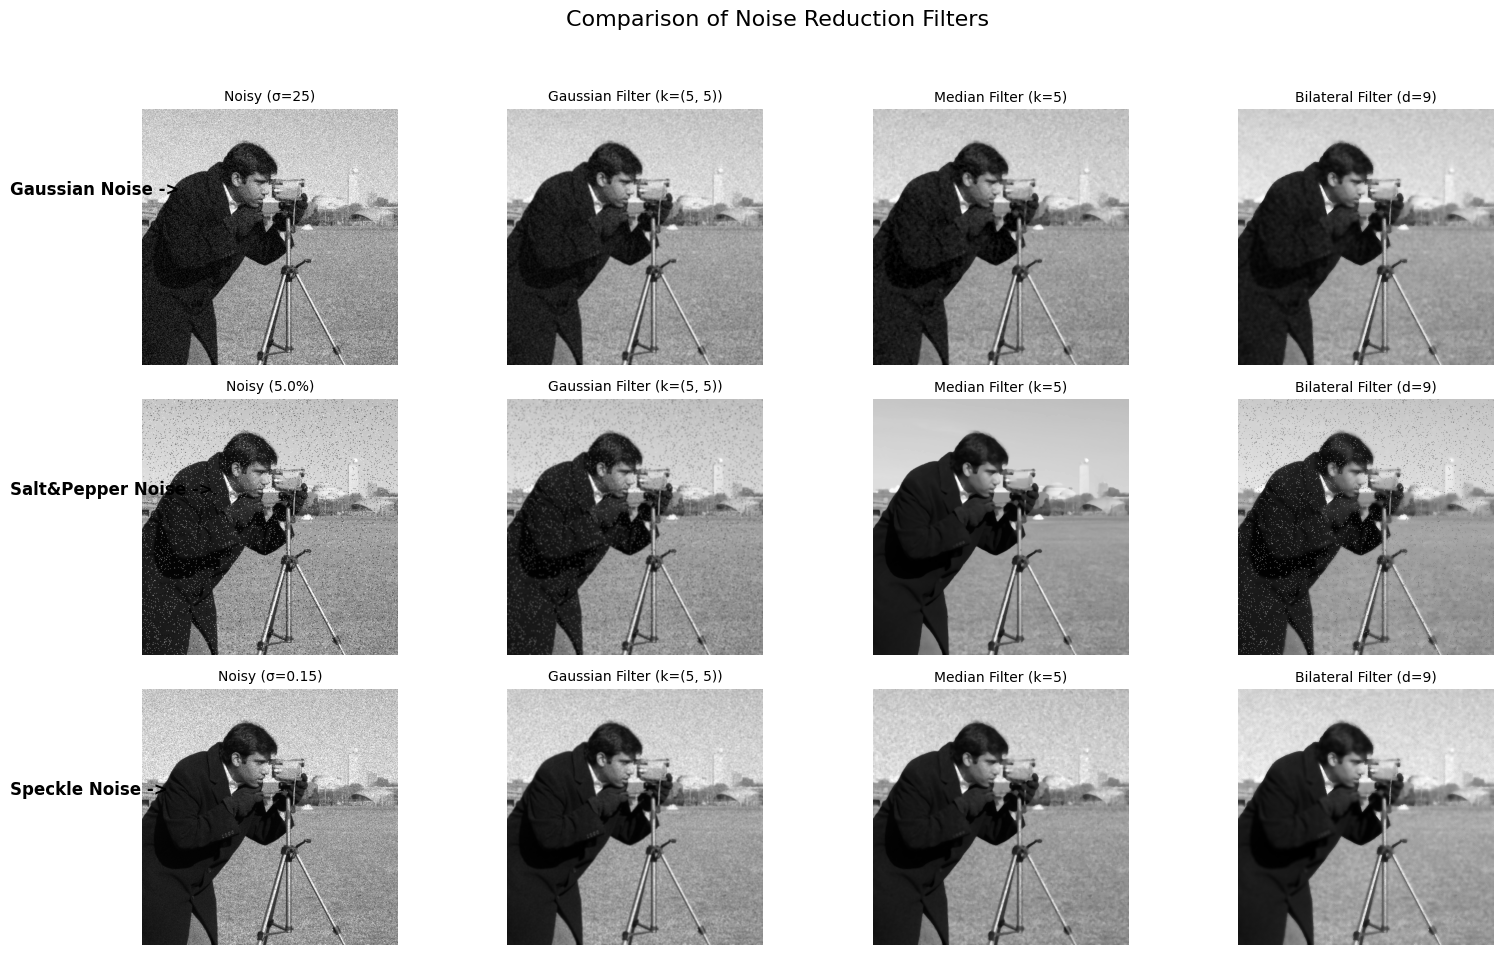

In [ ]:
if gray_image is not None:
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    cmap = 'gray'
    label_fontsize = 12
    title_fontsize = 10

    
    row_label_y = 0.80 
    fig.text(0.02, row_label_y, 'Gaussian Noise ->', fontsize=label_fontsize, va='center', ha='left', weight='bold')

    axes[0, 0].imshow(gaussian_noisy, cmap=cmap)
    axes[0, 0].set_title(f'Noisy (σ={gaussian_sigma})', fontsize=title_fontsize)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(gauss_filtered_g, cmap=cmap)
    axes[0, 1].set_title(f'Gaussian Filter (k={gaussian_ksize})', fontsize=title_fontsize)
    axes[0, 1].axis('off')

    axes[0, 2].imshow(median_filtered_g, cmap=cmap)
    axes[0, 2].set_title(f'Median Filter (k={median_ksize})', fontsize=title_fontsize)
    axes[0, 2].axis('off')

    axes[0, 3].imshow(bilateral_filtered_g, cmap=cmap)
    axes[0, 3].set_title(f'Bilateral Filter (d={bilateral_d})', fontsize=title_fontsize)
    axes[0, 3].axis('off')

    row_label_y = 0.50 
    fig.text(0.02, row_label_y, 'Salt&Pepper Noise ->', fontsize=label_fontsize, va='center', ha='left', weight='bold')

    axes[1, 0].imshow(salt_pepper_noisy, cmap=cmap)
    axes[1, 0].set_title(f'Noisy ({sp_amount*100:.1f}%)', fontsize=title_fontsize)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(gauss_filtered_sp, cmap=cmap)
    axes[1, 1].set_title(f'Gaussian Filter (k={gaussian_ksize})', fontsize=title_fontsize)
    axes[1, 1].axis('off')

    axes[1, 2].imshow(median_filtered_sp, cmap=cmap)
    axes[1, 2].set_title(f'Median Filter (k={median_ksize})', fontsize=title_fontsize)
    axes[1, 2].axis('off')

    axes[1, 3].imshow(bilateral_filtered_sp, cmap=cmap)
    axes[1, 3].set_title(f'Bilateral Filter (d={bilateral_d})', fontsize=title_fontsize)
    axes[1, 3].axis('off')

    row_label_y = 0.20
    fig.text(0.02, row_label_y, 'Speckle Noise ->', fontsize=label_fontsize, va='center', ha='left', weight='bold')

    axes[2, 0].imshow(speckle_noisy, cmap=cmap)
    axes[2, 0].set_title(f'Noisy (σ={speckle_sigma})', fontsize=title_fontsize)
    axes[2, 0].axis('off')

    axes[2, 1].imshow(gauss_filtered_s, cmap=cmap)
    axes[2, 1].set_title(f'Gaussian Filter (k={gaussian_ksize})', fontsize=title_fontsize)
    axes[2, 1].axis('off')

    axes[2, 2].imshow(median_filtered_s, cmap=cmap)
    axes[2, 2].set_title(f'Median Filter (k={median_ksize})', fontsize=title_fontsize)
    axes[2, 2].axis('off')

    axes[2, 3].imshow(bilateral_filtered_s, cmap=cmap)
    axes[2, 3].set_title(f'Bilateral Filter (d={bilateral_d})', fontsize=title_fontsize)
    axes[2, 3].axis('off')

    fig.suptitle('Comparison of Noise Reduction Filters', fontsize=16)
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95]) 
                                                
    print("Displaying final comparison plot.")
    plt.show()

